<a href="https://colab.research.google.com/github/kunalrye/COVID19/blob/master/COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import cufflinks as cf
import plotly.graph_objs as go
import plotly.express as px
from scipy.optimize import curve_fit
from typing import List
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn 
import bokeh 

In [15]:
daily_jhu_report_url_base = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/%s.csv"
def gather_daily_jhu_reports(date_rng):
    collected = pd.DataFrame()
    for date in date_rng:
        date_str = date.strftime("%m-%d-%Y")
        print("Collecting data from: %s" % date_str)
        try:
            daily_report = pd.read_csv(daily_jhu_report_url_base % date_str)
            daily_report.insert(0, "Date", date)
            daily_report.rename(columns={
                'Country_Region':'Country/Region', 
                "Province_State": "Province/State", 
                "Last_Update": "Last Update",
                "Lat": "Latitude",
                "Long_": "Longitude"
            }, inplace=True)
            collected = pd.concat([collected, daily_report], axis=0, ignore_index=True)
        except:
            print("FAILED TO FETCH DATA FOR: %s" % date_str)
    return collected
report_data = gather_daily_jhu_reports(pd.date_range("1-22-2020", "03-25-2020").to_pydatetime())
report_data.to_csv("daily_jhu_report_data.csv", index=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [0]:
jhu_data = pd.read_csv("daily_jhu_report_data.csv")
selector = np.logical_or(
    jhu_data["Combined_Key"] == "Texas, US", 
    jhu_data["Province/State"] == "Texas"
)
selector = np.logical_or(selector, jhu_data["Province/State"] == "Texas")
jhu_tx_data = jhu_data[selector]
jhu_tx_data = jhu_tx_data.dropna()

In [85]:
jhu_tx_data.head(5)

,Active,Admin2,Combined_Key,Confirmed,Country/Region,Date,Deaths,FIPS,Last Update,Latitude,Longitude,Province/State,Recovered
7916,0.0,Dallas,"Dallas, Texas, US",131.0,US,2020-03-22,2.0,48113.0,3/22/20 23:45,32.766706,-96.777961,Texas,0.0
7917,0.0,Harris,"Harris, Texas, US",74.0,US,2020-03-22,1.0,48201.0,3/22/20 23:45,29.858649,-95.393395,Texas,0.0
7918,0.0,Travis,"Travis, Texas, US",62.0,US,2020-03-22,0.0,48453.0,3/22/20 23:45,30.334320,-97.785356,Texas,0.0
7919,0.0,Tarrant,"Tarrant, Texas, US",47.0,US,2020-03-22,1.0,48439.0,3/22/20 23:45,32.771438,-97.291016,Texas,0.0
7920,0.0,Bexar,"Bexar, Texas, US",46.0,US,2020-03-22,1.0,48029.0,3/22/20 23:45,29.449287,-98.520197,Texas,0.0


In [86]:
txlatmin = jhu_tx_data.Latitude.min()
txlatmax = jhu_tx_data.Latitude.max()
txlongmin = jhu_tx_data.Longitude.min()
txlongmax = jhu_tx_data.Longitude.max()
display(txlatmin, txlatmax,txlongmin,txlongmax)

26.14524221

36.27829105

-106.2363275

-93.74408813

In [0]:
dfw = plt.imread("/content/drive/My Drive/COVID/largerarea.png")

In [0]:
latmin = 32.3304
latmax = 33.3607
longmin = -97.8001
longmax = -96.0354
BBox = (longmin, longmax, latmin, latmax)

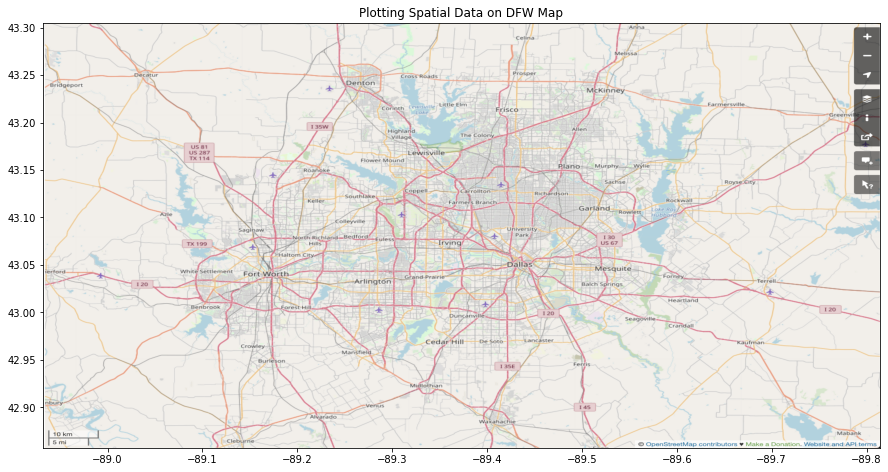

In [112]:
fig, ax = plt.subplots(figsize = (15,48))
ax.scatter(jhu_tx_data.Longitude, jhu_tx_data.Latitude, zorder=1, alpha= 0.5, c='r', s=jhu_tx_data['Confirmed']*4)
ax.set_title('Plotting Spatial Data on DFW Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(dfw, zorder=0, extent = BBox, aspect= 'equal')